In [1]:
import numpy as np
import pandas as pd

PARTICIPANT_ID='Sub01'

df_csv=pd.read_csv('data/Provo_Corpus-Eyetracking_Data(sub1-10).csv',usecols=['Participant_ID','Text_ID','Word_Cleaned','IA_SKIP'])
df_csv=df_csv[(df_csv['Participant_ID']==PARTICIPANT_ID)]
df_csv=df_csv.drop(['Participant_ID'],axis=1) #删除列，轴为1
df_csv=df_csv.fillna(' ')
list_data=[]
for j in range(1,56): #句子1-55
    df=df_csv[(df_csv['Text_ID']==j)][['Word_Cleaned','IA_SKIP']] #只保留'Word_Cleaned','IA_SKIP'两列
    mylist = np.array(df).tolist()
    list_data.append(mylist)

texts=[[j[0] for j in i]for i in list_data]
labels=[[j[1] for j in i]for i in list_data]
#print(labels)

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_NB_WORDS = 2000 #字典大小
MAX_SEQUENCE_LENGTH = max(len(s) for s in texts)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
MAX_NB_WORDS = len(word_index)+1 #重新修正字典大小
#print(word_index)
x = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)  # left padding
#print(x)
y = pad_sequences(labels, MAX_SEQUENCE_LENGTH, value=-1)  # left padding
y = np.expand_dims(y, 2)
#print(y)
train_x=x[0:45]
train_y=y[0:45]
test_x=x[45:]
test_y=y[45:]

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM,Dense, Conv1D, GlobalMaxPooling1D,TimeDistributed
from keras_contrib.layers import CRF

EMBEDDING_DIM = 200
BiRNN_UNITS = 200

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, mask_zero=True))  # Random embedding

#model.add(Bidirectional(LSTM(BiRNN_UNITS // 2, return_sequences=True)))

crf = CRF(2, sparse_target=True)
model.add(crf)
model.summary()
model.compile(optimizer='adam', loss=crf.loss_function, metrics=[crf.accuracy])


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         238600    
_________________________________________________________________
crf_1 (CRF)                  (None, None, 2)           410       
Total params: 239,010
Trainable params: 239,010
Non-trainable params: 0
_________________________________________________________________


C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


In [4]:
EPOCHS = 10

# train model
train_history=model.fit(train_x, train_y,batch_size=4,epochs=EPOCHS, validation_data=[test_x, test_y])
model.save('model/crf.h5')

Instructions for updating:
Use tf.cast instead.
Train on 45 samples, validate on 10 samples
Epoch 1/10
45/45 [==============================] - 1s 32ms/step - loss: 0.8285 - crf_viterbi_accuracy: 0.6774 - val_loss: 0.9000 - val_crf_viterbi_accuracy: 0.5826
Epoch 2/10
45/45 [==============================] - 0s 7ms/step - loss: 0.7696 - crf_viterbi_accuracy: 0.6767 - val_loss: 0.8478 - val_crf_viterbi_accuracy: 0.5825
Epoch 3/10
45/45 [==============================] - 0s 7ms/step - loss: 0.7076 - crf_viterbi_accuracy: 0.6793 - val_loss: 0.8010 - val_crf_viterbi_accuracy: 0.5845
Epoch 4/10
45/45 [==============================] - 0s 7ms/step - loss: 0.6482 - crf_viterbi_accuracy: 0.7231 - val_loss: 0.7657 - val_crf_viterbi_accuracy: 0.6663
Epoch 5/10
45/45 [==============================] - 0s 7ms/step - loss: 0.5985 - crf_viterbi_accuracy: 0.7606 - val_loss: 0.7515 - val_crf_viterbi_accuracy: 0.6867
Epoch 6/10
45/45 [==============================] - 0s 8ms/step - loss: 0.5661 - crf_vi

In [5]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()


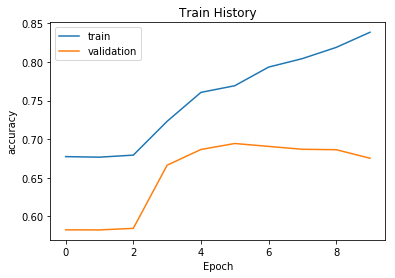

In [6]:
show_train_history(train_history,'crf_viterbi_accuracy','val_crf_viterbi_accuracy')